In [70]:
import numpy as np

def one_hot(Y: np.ndarray, num_class) -> np.array: # TESDED
    one_hot_Y = np.zeros((Y.shape[0], num_class)) 
    one_hot_Y[np.arange(Y.shape[0]), Y] += 1
    return one_hot_Y



class LinearClassifier:
    def __init__(self, n_features:int, n_classes:int, init_weights:np.array,  lambda_l2:float = 0.1):
        self.bias = np.random.rand(n_classes)-0.5
        self.Weights = init_weights
        self.weights_grad = np.zeros((n_features, n_classes))
        self.bias_grad = np.zeros((n_classes))
        self.n_classes = n_classes
        self.input = None
        self.alpha = None
        self.lambda_l2 = lambda_l2

    def __call__(self, X:np.ndarray):
        self.input = X.copy()
        self.output = X @ self.Weights + self.bias

        return self.output
    
    def backprop(self, grads_per_class:np.ndarray, Y_pred:np.ndarray, Y_real:np.ndarray):
        # print(f"{self.input=}")
        # print(f"{grads_per_class=}")
        # print(f"{self.Weights=}")
        self.weights_grad = self.input.T @ grads_per_class 
        # print(f"{Y_pred=}")
        # print(f"{Y_real=}")
        # print(f"{self.weights_grad=}")
        logits_updated = self.input @ self.weights_grad

        numerator = np.sum(np.array([np.sum((Y_pred[:, i] - (Y_real[:, i]==1)) * logits_updated[:,i]) for i in range(self.Weights.shape[1])]))
        denominator = np.sum(np.array([np.sum(logits_updated[:, i] ** 2) for i in range(self.Weights.shape[1])]))


        self.alpha = numerator / denominator #if denominator != 0 else 0.0
        # print(self.alpha)
        self.weights_grad += 2 * self.lambda_l2 * self.Weights
        # print(f"{self.weights_grad=}")
        self.bias_grad = np.sum(grads_per_class, axis=0)


    def apply_grad(self):
        self.Weights -= self.weights_grad
        self.bias -= self.bias_grad





class LinearLoss:
    def __init__(self, n_classes:int, loss_type:str = "sigmoid", lr:float = 0.001):
        self.n_classes = n_classes
        self.loss_type = loss_type
        self.lr = lr
        self.Y_real = None
    
    def sigmoid(self, X:np.ndarray):
         return 1 / (1 + np.exp(-X))
    
    def __call__(self, Y_logit:np.ndarray, Y_real:np.ndarray):
        Y_real = one_hot(Y_real, self.n_classes)
        self.Y_real = Y_real
        # print(f"{Y_real=}")

        if self.loss_type == "sigmoid":
            self.Y_pred = self.sigmoid(Y_logit)
            gradient_func = lambda y_pred, y_real: (y_pred - y_real)

        
        

        return np.array([gradient_func(self.Y_pred[:, i], self.Y_real[:, i]==1) for i in range(self.n_classes)]).T, self.Y_pred, self.Y_real

    def get_loss(self):
        loss = np.sum([-(self.Y_real[:, i]==1).astype(int) * np.log(self.Y_pred[:, i]) - (1 - (self.Y_real[:, i]==1).astype(int)) * np.log(1 - self.Y_pred[:, i]) for i in range(self.n_classes)])
        return loss
    


class BatchGenerator:  # TESTED
    def __init__(self, X: np.ndarray, Y: np.ndarray, batch_size: int, linear:LinearClassifier, loss_fn:LinearLoss, shuffle: bool = True, ):
        """
        X: np.ndarray
            Входные данные, размеры [n_samples, n_features]
        Y: np.ndarray
            Метки данных, размеры [n_samples] или [n_samples, n_classes]
        batch_size: int
            Размер мини-батча
        shuffle: bool
            Перемешивать ли данные перед каждой эпохой
        """
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = X.shape[0]  # Количество примеров
        self.indices = np.arange(self.num_samples)  # Индексы для перемешивания
        self.linear = linear
        self.Y_real = one_hot(Y, self.linear.n_classes)
        self.loss_fn = loss_fn

    def __iter__(self):
        """
        Итератор для перебора батчей.
        """
        if self.shuffle:
            # print("Перемешано")
            # Перемешиваем индексы в начале каждой эпохи
            np.random.shuffle(self.indices)
        
        
        # print(self.indices)
        # Возвращаем батчи данных
        # selected_indices = np.random.choice(np.arange(len(self.X)), size=self.batch_size, p=margin_probabilities)
        # margin_probabilities = np.sum(np.array([(self.Y_real[:, i]==1) * self.linear(self.X)[:, i] for i in range(self.linear.n_classes)]),  axis=0)
        for start_idx in range(0, self.num_samples - self.batch_size + 1, self.batch_size):
            margin_probabilities = 1 / np.sum(np.array([(self.Y_real[:, i]==1) * self.loss_fn.sigmoid(self.linear(self.X))[:, i] for i in range(self.linear.n_classes)]),  axis=0)
            margin_probabilities /= np.sum(margin_probabilities)
            selected_indices = np.random.choice(self.indices, size=self.batch_size, p=margin_probabilities)
            # end_idx = start_idx + self.batch_size  
            # batch_indices = self.indices[start_idx:end_idx]
            # # print(batch_indices)
            # print(self.Y[selected_indices])
            yield self.X[selected_indices], self.Y[selected_indices]

    def __len__(self):
        """
        Возвращает количество батчей за одну эпоху.
        """
        return (self.num_samples // self.batch_size)


class AdamOptimizer:
    def __init__(self, layer:LinearClassifier, beta1:float=0.9, beta2:float=0.99, debug=False): #learning_rate:float,
        self.V_w = np.zeros(layer.weights_grad.shape)
        self.A_w = np.zeros(layer.weights_grad.shape)
        self.V_b = np.zeros(layer.bias_grad.shape)
        self.A_b = np.zeros(layer.bias_grad.shape)
        self.layer_amm = 1
        self.beta1 = beta1
        self.beta2 = beta2
        self.layer = layer
        # self.learning_rate = learning_rate
        self.iteration = 1
        self.debug = debug

    def step(self):
    
        if self.debug:
            print(self.V_w)
        
        # Коррекция для весов
        self.V_w = self.beta1 * self.V_w + (1 - self.beta1) * self.layer.weights_grad
        self.A_w = self.beta2 * self.A_w + (1 - self.beta2) * self.layer.weights_grad ** 2
        self.V_b = self.beta1 * self.V_b + (1 - self.beta1) * self.layer.bias_grad
        self.A_b = self.beta2 * self.A_b + (1 - self.beta2) * self.layer.bias_grad ** 2
        self.layer.weights_grad = self.layer.alpha * ((self.V_w / (1 - self.beta1 ** self.iteration)) 
                                                                        / (np.sqrt(self.A_w / (1 - self.beta2 ** self.iteration)) + 0.0001))
        self.layer.bias_grad =  self.layer.alpha * ((self.V_b/(1-self.beta1 ** self.iteration)) 
                                                                           / (np.sqrt(self.A_b / (1 - self.beta2 ** self.iteration)) + 0.0001))

        self.layer.apply_grad()

        self.iteration += 1


def Accuracy(y_pred_softmax: np.ndarray, y_real: np.ndarray) -> float:
    # print(y_pred_softmax)
    return np.sum(np.argmax(y_pred_softmax, axis=1)==y_real)/y_real.shape[0]


def train_test_split(X: np.ndarray, Y: np.ndarray, test_size:float=0.3, shuffle:bool=True):
    indices = np.arange(X.shape[0])

    if shuffle:
        np.random.shuffle(indices)

    train_end_ind = int(X.shape[0] * (1-test_size)+1)

    return X[:train_end_ind], Y[:train_end_ind], X[train_end_ind:], Y[train_end_ind:]



My calc time is 1.9151034355163574


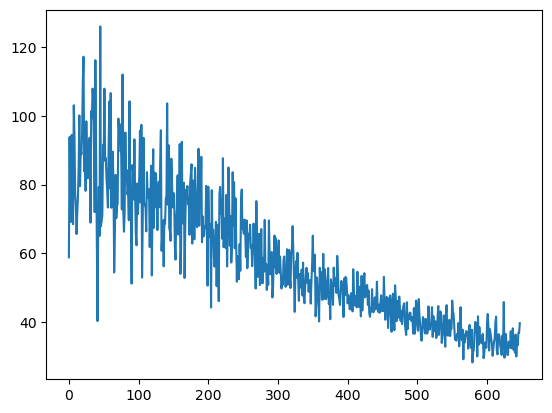

In [77]:

import pandas as pd
import matplotlib.pyplot as plt
url = "./mushrooms.csv"
dataset = pd.read_csv(url)
dataset.head(10)

for column in dataset.columns[1:]:
    unics = dataset[column].unique()
    transform = {unic:i+1 for i, unic in enumerate(dataset[column].unique())}
    dataset[column] = dataset[column].apply(lambda x: transform[x])

transform = {"e":0, "p":1}
dataset["class"] = dataset["class"].apply(lambda x: transform[x])
dataset.head(10)

X = dataset[dataset.columns[1:]].to_numpy()
Y = dataset["class"].to_numpy()

x_train, y_train, x_test, y_test = train_test_split(X=X, Y=Y, test_size=0.2)
# print(x_train)

def random_init(n_features, n_classes):
    return np.random.rand(n_features, n_classes) - 0.5

def init_corr(X, Y):
    correlations = np.corrcoef(X, Y, rowvar=False)
    correlations =  np.where(np.isnan(correlations[-1, :-1]), 0, correlations[-1, :-1])
    correlations =np.tile(correlations , reps=(2,1)).T
    return correlations




loss = LinearLoss(n_classes=2)
np.random.seed(3)                                          #init_corr(X, Y)
linear = LinearClassifier(n_features=22, n_classes=2, init_weights=random_init(22, 2))
optimizer = AdamOptimizer(linear)

train_batch_gen = BatchGenerator(x_train, y_train, batch_size=30, shuffle=True, linear=linear, loss_fn=loss)
losses = []

import time

start = time.time()
for epoch in range(3):
    for x,y in train_batch_gen:
        out = linear(x)
        grads = loss(out, y)
        losses.append(loss.get_loss())
        # print(loss.get_loss())
        linear.backprop(*grads)
        optimizer.step()
        
print(f"My calc time is {time.time()-start}")
import matplotlib.pyplot as plt

plt.plot(np.arange(len(losses)), losses)

    

In [78]:
Accuracy(loss.sigmoid(linear(x_test)), y_test)
# print(y_test)
# print(linear(x_test))
# print(y_test)

0.8300492610837439

In [69]:
print(linear.bias)

[-0.09748116 -0.96019488]


In [46]:
from sklearn.linear_model import SGDClassifier
start = time.time()
classifier = SGDClassifier(
    loss="log_loss",           # Логистическая регрессия для вероятностного выхода
    penalty="l2",         # L2 регуляризация
    max_iter=30,        # Максимальное количество итераций
    tol=1e-3,             # Допуск для останова
    alpha=0.001,          # Коэффициент регуляризации
    random_state=42
)

# Обучение классификатора
classifier.fit(x_train, y_train.reshape(-1, 1))

# Предсказание на тестовых данных
y_pred = classifier.predict_proba(x_test)
print(f"SKLEARN calc time is {time.time()-start}")
# Оценка модели
accuracy = Accuracy(y_pred, y_test)
print(accuracy)

SKLEARN calc time is 0.013003826141357422
0.8171182266009852


d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


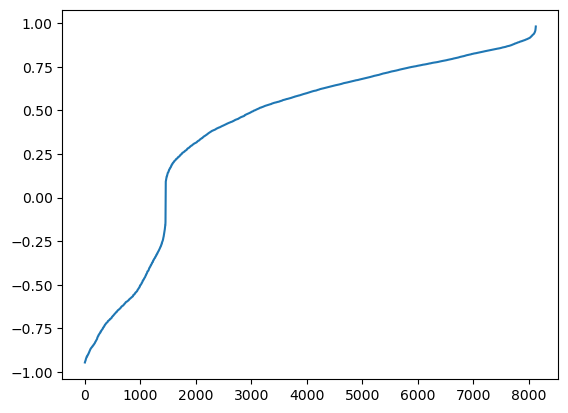

In [79]:
sigm_predicted = loss.sigmoid(linear(X))
predicted = np.argmax(sigm_predicted, axis=1)
predicted_rw = np.where(predicted==Y, 1, -1)
predicted
plt.plot(sorted(sigm_predicted[np.arange(predicted.shape[0]), predicted]*predicted_rw))

In [7]:
sigm_predicted = loss.sigmoid(linear(X))
predicted = np.argmax(sigm_predicted, axis=1)
sigm_predicted
Y

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [ ]:
np.tile(np.corrcoef(X, Y, rowvar=False)[-1, :-1], reps=(2,1)).T

C:\Users\artbo\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\artbo\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[ 0.11211032, -0.16966305,  0.04202825,  0.50153038,  0.58201543,
        -0.12919986, -0.34838679, -0.54002436,  0.41286943, -0.10201902,
         0.3375417 ,  0.55204364,  0.53245229,  0.22529398,  0.09847579,
                nan, -0.12076594, -0.15226082,  0.55651472,  0.56071523,
         0.15525371,  0.19129694],
       [ 0.11211032, -0.16966305,  0.04202825,  0.50153038,  0.58201543,
        -0.12919986, -0.34838679, -0.54002436,  0.41286943, -0.10201902,
         0.3375417 ,  0.55204364,  0.53245229,  0.22529398,  0.09847579,
                nan, -0.12076594, -0.15226082,  0.55651472,  0.56071523,
         0.15525371,  0.19129694]])

array([ 0.11211032, -0.16966305,  0.04202825,  0.50153038,  0.58201543,
       -0.12919986, -0.34838679, -0.54002436,  0.41286943, -0.10201902,
        0.3375417 ,  0.55204364,  0.53245229,  0.22529398,  0.09847579,
               nan, -0.12076594, -0.15226082,  0.55651472,  0.56071523,
        0.15525371,  0.19129694])

In [30]:
for j in range(22):
    X_j = X[:, j]
    print(np.corrcoef(X_j, Y)[0, 1])

0.11211031703516394
-0.1696630540517295
0.04202825176197811
0.5015303774075575
0.5820154327236085
-0.12919986026788396
-0.34838678518427396
-0.5400243574330174
0.4128694256416521
-0.10201901701656056
0.3375417049996676
0.5520436410013894
0.53245229042052
0.22529398127468042
0.09847579450544268
nan
-0.12076593697596338
-0.15226082429665588
0.5565147182889624
0.5607152345831516
0.1552537114255421
0.19129693972598538


C:\Users\artbo\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\artbo\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [82]:
Weights = None
bias = None
now_acc = 0
for start_n in range(5):
    seed = int(np.random.rand()*1000)
    np.random.seed(seed)
    linear = LinearClassifier(n_features=22, n_classes=2, init_weights=random_init(22, 2))
    optimizer = AdamOptimizer(linear)
    

    for epoch in range(8):
        for x,y in train_batch_gen:
            out = linear(x)
            grads = loss(out, y)
            losses.append(loss.get_loss())
            # print(loss.get_loss())
            linear.backprop(*grads)
            optimizer.step()
    
    accuracy = Accuracy(loss.sigmoid(linear(x_test)), y_test)
    print(f"now {accuracy=}")
    if accuracy > now_acc:
        Weights = linear.Weights
        bias = linear.bias
        now_acc = accuracy
    
        print("updated")


        

now accuracy=0.75
updated
now accuracy=0.7801724137931034
updated
now accuracy=0.7967980295566502
updated
now accuracy=0.7635467980295566
now accuracy=0.7475369458128078
